# Regression with Random Forest & Amazon SageMaker XGBoost algorithm

---
## Introduction

This notebook demonstrates training and hosting a regression model using :
1. Random Forest algorithm in scikit-learn using Sagemaker Python SDK
2. Amazon SageMaker’s implementation of the XGBoost algorithm

The steps include:

1. Preparing your Amazon SageMaker notebook
2. Downloading data from the internet into Amazon SageMaker
3. Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
4. Estimating a model using the Random Forest and XG Boost algorithm
5. Evaluating the effectiveness of the model
6. Setting the model up to make on-going predictions


We use [KaggleDatasets : House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction). This dataset contains house sale prices for King County in Seattle,sold between May 2014 and May 2015.

It's a great dataset for evaluating simple regression models.


### Setup


This notebook was created and tested on an ml.t2.medium notebook instance.

Boto is the Amazon Web Services (AWS) SDK for Python. It enables Python developers to create, configure, and manage AWS services, such as EC2 and S3. Boto provides an easy to use, object-oriented API, as well as low-level access to AWS services.

Let's start by specifying the S3 bucket that you want to use for storing training and model data. This should be within the same region as the Notebook Instance, training, and hosting.


In [26]:
import datetime
import tarfile

import boto3
from sagemaker import get_execution_role
import sagemaker

m_boto3 = boto3.client('sagemaker')

sess = sagemaker.Session()

region = sess.boto_session.region_name

bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

print('Using bucket ' + bucket)

Using bucket sagemaker-us-east-1-262760754591


### Fetching-the-dataset

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

data = pd.read_csv("kc_house_data.csv", parse_dates=['date'])

### Exploration

Let's start exploring the data. First, let's understand how the features are distributed.

In [28]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


In [30]:
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,2014-10-15,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [31]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Feature Engineering and Data Visualizations:

Next, let's look at how our features relate to the target that we are attempting to predict.

In [32]:
data['years_renovated'] = data['yr_renovated'] - data['yr_built']

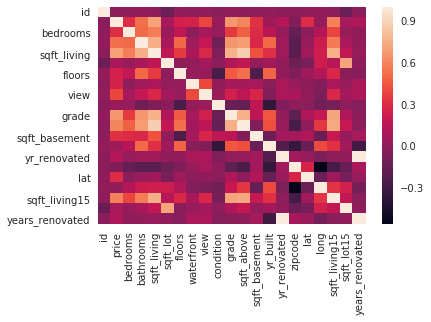

In [33]:
numeric_data = ['id','price','bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15','years_renovated']
numeric_analysis = pd.DataFrame(data[numeric_data]).corr()
sns.heatmap(numeric_analysis)

In [34]:
attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15','years_renovated']

y_data = data['price']
x_data = data [attributes]

### Preparing the data

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=1)

In [36]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17290, 19), (4323, 19), (17290,), (4323,))

In [37]:
x_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_renovated
7291,3,1.75,2190,7021,1.0,0,2,4,7,1390,800,1953,0,98178,47.5033,-122.232,2180,7155,-1953
14835,3,2.50,2370,6840,2.0,0,0,3,9,2370,0,1987,0,98119,47.6503,-122.366,1590,4400,-1987
15880,2,1.00,1230,3800,1.0,0,0,3,7,1230,0,1928,0,98115,47.6797,-122.292,1610,3800,-1928
8812,4,2.25,2510,9963,1.0,0,0,4,9,2200,310,1967,0,98005,47.5973,-122.177,3110,9963,-1967
17220,3,1.00,1160,7491,1.0,0,0,4,6,1160,0,1917,0,98177,47.7024,-122.359,1800,2267,-1917


In [38]:
trainX = pd.DataFrame(x_train, columns=attributes)
trainX['target'] = y_train

testX = pd.DataFrame(x_test, columns=attributes)
testX['target'] = y_test

In [39]:
trainX.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_renovated,target
7291,3,1.75,2190,7021,1.0,0,2,4,7,1390,800,1953,0,98178,47.5033,-122.232,2180,7155,-1953,353000.0
14835,3,2.50,2370,6840,2.0,0,0,3,9,2370,0,1987,0,98119,47.6503,-122.366,1590,4400,-1987,300523.0
15880,2,1.00,1230,3800,1.0,0,0,3,7,1230,0,1928,0,98115,47.6797,-122.292,1610,3800,-1928,435000.0
8812,4,2.25,2510,9963,1.0,0,0,4,9,2200,310,1967,0,98005,47.5973,-122.177,3110,9963,-1967,800000.0
17220,3,1.00,1160,7491,1.0,0,0,4,6,1160,0,1917,0,98177,47.7024,-122.359,1800,2267,-1917,417500.0


In [40]:
trainX.to_csv('housing_train.csv')
testX.to_csv('housing_test.csv')

### Data Ingestion

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [41]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path='housing_train.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

testpath = sess.upload_data(
    path='housing_test.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

### Writing a Script Mode script

The below script contains both training and inference functionality and can run both in SageMaker Training hardware or locally (desktop, SageMaker notebook, on prem, etc). Detailed guidance here https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script

In [42]:
%%writefile script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import explained_variance_score, r2_score



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max_leaf_nodes', type=int, default=10)
    

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='housing_train.csv')
    parser.add_argument('--test-file', type=str, default='housing_test.csv')
    
    args, _ = parser.parse_known_args()
    
    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15','years_renovated']
    X_train = train_df[attributes]
    X_test = test_df[attributes]
    y_train = train_df['target']
    y_test = test_df['target']
    
    # train
    print('training model')
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        max_leaf_nodes =args.max_leaf_nodes,
        n_jobs=-1)
    
    model.fit(X_train, y_train)
     
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)
    
    # print explained_variance_score 
    print('validating model')
    predictions = model.predict(X_test)
    print("Explained Variance Score is " + str(explained_variance_score(y_test, predictions).round(2)))
    print("R2 score : %.2f" % r2_score(y_test,predictions))
  

Writing script.py


## Local Training

Script arguments allows us to remove from the script any SageMaker-specific configuration, and run locally

In [43]:
! python script.py --n-estimators 500 \
                   --max-leaf-nodes 16 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   

extracting arguments
reading data
building training and testing datasets
training model
model persisted at ./model.joblib
validating model
Explained Variance Score is 0.68
R2 score : 0.68


## SageMaker Training

### Launching a training job with the Python SDK

In [44]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    entry_point='script.py',
    role = get_execution_role(),
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    framework_version='0.20.0',
    base_job_name='rf-scikit',
    hyperparameters = {'n-estimators': 500,
                       'max_leaf_nodes': 16
                       })

In [45]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train':trainpath, 'test': testpath}, wait=False)

## Deploy to a real-time endpoint


### Deploy with Python SDK

An Estimator could be deployed directly after training, with an Estimator.deploy() but here we showcase the more extensive process of creating a model from s3 artifacts, that could be used to deploy a model that was trained in a different session or even out of SageMaker.

In [46]:
sklearn_estimator.latest_training_job.wait(logs='None')
artifact = m_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

print('Model artifact persisted at ' + artifact)


2020-04-23 17:36:05 Starting - Starting the training job
2020-04-23 17:36:07 Starting - Launching requested ML instances............
2020-04-23 17:37:13 Starting - Preparing the instances for training..........
2020-04-23 17:38:08 Downloading - Downloading input data......
2020-04-23 17:38:41 Training - Downloading the training image..
2020-04-23 17:39:00 Training - Training image download completed. Training in progress....
2020-04-23 17:39:17 Uploading - Uploading generated training model
2020-04-23 17:39:24 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-262760754591/rf-scikit-2020-04-23-17-36-04-818/output/model.tar.gz


In [47]:
predictor = sklearn_estimator.deploy(instance_type='ml.m4.xlarge',initial_instance_count=1)

---------------!

### Invoke with the Python SDK

In [48]:
attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15','years_renovated']
print(predictor.predict(testX[attributes]))

[ 520301.71428889  465616.70020037  542572.97564167 ...  275252.41796161
 2008357.66889743  459956.8802124 ]


In [50]:
predictions = predictor.predict(testX[attributes])

In [52]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(testX['target'],predictions))

R2 score : 0.73


### Don't forget to delete the endpoint !

In [53]:
sagemaker.Session().delete_endpoint(predictor.endpoint)
# bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
# bucket_to_delete.objects.all().delete()

## XG Boost Algorithm

In [54]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role and assign S3 bucket
role = get_execution_role()
prefix = 'sagemaker/wimlds-sagemaker-xgboost-demo'
bucket_name = 'sagemaker-us-east-1-262760754591' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container

my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


### Prepare the data

In [55]:
train_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data))])
print(train_data.shape, test_data.shape)

(15129, 22) (6484, 22)


In [56]:
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_renovated
17399,5153900080,2014-07-14,199000.0,3,1.00,1510,9100,1.0,0,0,...,1510,0,1966,0,98003,47.3331,-122.319,1180,7220,-1966
16005,2754700095,2015-03-16,747000.0,3,1.50,1710,5120,2.0,0,0,...,1710,0,1920,0,98115,47.6801,-122.305,1530,5170,-1920
8382,4399200100,2015-04-28,288000.0,3,2.25,1560,9706,1.0,0,0,...,1560,0,1963,0,98002,47.3191,-122.213,1510,9706,-1963
7381,3897100275,2014-10-27,460000.0,3,1.75,1660,9900,2.0,0,0,...,1660,0,1978,0,98033,47.6704,-122.184,1720,6600,-1978
16824,9477201470,2014-10-22,379950.0,3,1.00,1270,6900,1.0,0,0,...,1270,0,1977,0,98034,47.7279,-122.192,1480,7280,-1977


In [57]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'years_renovated'],
      dtype='object')

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers. Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before. This avoids any misalignment issues due to random reordering.

In [58]:
attributes = ['price','id', 'date', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'years_renovated']
train_data = train_data[attributes]

In [59]:
train_data.to_csv('train.csv', index=False, header=False)

### Upload training data to S3 Bucket

In [60]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

### Training

In [61]:
sess = sagemaker.Session()

In [62]:
xgb = sagemaker.estimator.Estimator(containers[my_region],role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100)

In [63]:
xgb.fit({'train': s3_input_train})

2020-04-23 17:47:52 Starting - Starting the training job...
2020-04-23 17:47:53 Starting - Launching requested ML instances......
2020-04-23 17:49:09 Starting - Preparing the instances for training......
2020-04-23 17:50:22 Downloading - Downloading input data...
2020-04-23 17:50:51 Training - Downloading the training image...
2020-04-23 17:51:21 Uploading - Uploading generated training modelArguments: train
[2020-04-23:17:51:16:INFO] Running standalone xgboost training.
[2020-04-23:17:51:16:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-04-23:17:51:16:INFO] File size need to be processed in the node: 1.69mb. Available memory size in the node: 8487.07mb
[2020-04-23:17:51:16:INFO] Determined delimiter of CSV input is ','
[17:51:16] S3DistributionType set as FullyReplicated
[17:51:16] 15129x21 matrix with 317709 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[17:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra no


2020-04-23 17:51:28 Completed - Training job completed
Training seconds: 66
Billable seconds: 66


In [64]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

---------------!

### Evaluation

There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values. 

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.

In [65]:
test_data_array = test_data.drop(['price','date'], axis=1).values #load the data into an array

In [66]:
test_data_array

array([[ 5.46631073e+09,  3.00000000e+00,  2.50000000e+00, ...,
         1.74000000e+03,  2.62400000e+03, -1.98300000e+03],
       [ 7.95030329e+09,  3.00000000e+00,  1.75000000e+00, ...,
         1.11000000e+03,  6.00000000e+03, -1.95100000e+03],
       [ 3.03420066e+09,  3.00000000e+00,  2.50000000e+00, ...,
         1.93000000e+03,  7.20600000e+03, -2.00300000e+03],
       ...,
       [ 4.31070160e+09,  3.00000000e+00,  2.50000000e+00, ...,
         1.41000000e+03,  1.35500000e+03, -2.00300000e+03],
       [ 5.56130128e+09,  3.00000000e+00,  2.25000000e+00, ...,
         2.73000000e+03,  3.64040000e+04, -1.97800000e+03],
       [ 2.32006925e+09,  3.00000000e+00,  1.00000000e+00, ...,
         1.21000000e+03,  8.98500000e+03, -1.95900000e+03]])

In [67]:
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type


In [68]:
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(6484,)


In [71]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(test_data['price'],predictions_array))

R2 score : -27.86


### Optional Clean-up

If you are done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [76]:
# sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
# bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
# bucket_to_delete.objects.all().delete()

[Amazon Sagemaker Pricing](https://aws.amazon.com/sagemaker/pricing/)

Try Amazon SageMaker for two months, free!

As part of the AWS Free Tier, you can get started with Amazon SageMaker for free. If you have never used Amazon SageMaker before, for the first two months, you are offered a monthly free tier of 250 hours of t2.medium or t3.medium notebook usage for building your models, plus 50 hours of m4.xlarge or m5.xlarge for training, plus 125 hours of m4.xlarge or m5.xlarge for deploying your machine learning models for real-time inferencing and batch transform with Amazon SageMaker. Your free tier starts from the first month when you create your first SageMaker resource.